## Оценка параметров дифференциального уравнения
При построении математических моделей нередко возникает ситуация, когда непосредственное измерение параметров, входящих в состав модели, невозможно по различным причинам. Одним из подходов решения данной проблемы является проведение идентификационных экспериментов и оценка параметров модели путем решения оптимизационной задачи.<br/>
Рассмотрим пример оценки параметров модели, представленной в виде системы дифференциальных уравнений (ДУ) в форме Коши.

### Исходные данные для задачи
*   Представление модели в форме Коши, первые *N* величин — наблюдаемы
*   Имеются данные эксперимента, на основе которого будет производится оценка параметров

In [ ]:
!pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 3.4 MB/s eta 0:00:00


In [ ]:
import pylab as pp
import numpy as np
from scipy import integrate, interpolate
from scipy import optimize
from scipy.integrate import odeint
from control.matlab import *

## Класс для оценки параметров ДУ в форме Коши
Процедуру оценки параметров можно реализовать на основе функции [scipy.optimize.leastsq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html). Эта функция минимизирует сумму квадратов полученных величин и может принимать два аргумента: вектор оцениваемых параметров и вектор ошибок.

Процедура оценки параметров работает следующим образом:  
1.   Вычисляется решение системы ДУ при текущих (или начальных) значения параметров.
2.   Рассчитывается вектор ошибки между решением и экспериментальными данными.
1.   Производится корректировка значений параметров.
2.   Переход на шаг 1, если не достигнуто максимальное число итераций или минимальное рассогласование.

In [ ]:
variant = 339840 % 20
print(variant)
print("y''(t) + 4y'(t) + 6y(t)  = -u'(t) -2u(t)")

0
y''(t) + 4y'(t) + 6y(t)  = -u'(t) -2u(t)


Мы можем ввести новую переменную, z(t), так что y'(t) = z(t) Тогда получаем систему Коши первого порядка:

{y'(t) = z(t)

{z'(t) = -4z(t) - 6y(t) + f(t), где f(t) = -u'(t) - 2u(t)

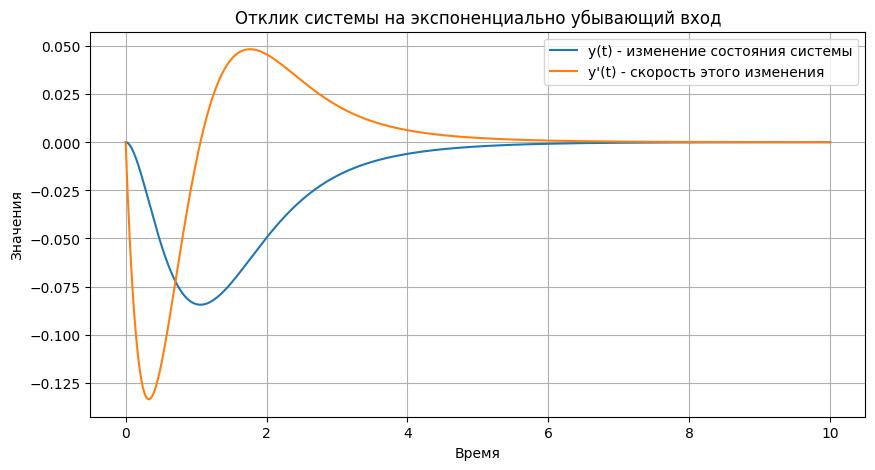

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Модель, представляющая систему дифференциальных уравнений
def system_of_equations(t, y, u_func, du_dt_func):
    y_t, z_t = y
    dy_dt = z_t
    dz_dt = -4 * z_t - 6 * y_t + (-du_dt_func(t) - 2 * u_func(t))
    return [dy_dt, dz_dt]

# Начальные условия
initial_conditions = [0, 0]  # y(0) = 0, y'(0) = 0

# Временной интервал для интегрирования
time_span = (0, 10)  # от 0 до 10
time_points = np.linspace(0, 10, 1000)  # 1000 точек на интервале = 100 точек на 1 сек, шаг = 10мс

#Эта функция представляет собой единичное воздействие, которое экспоненциально уменьшается со временем от значения 1 при t=0 до 0
def u(t):
    return np.exp(-t)

def du_dt(t):
    return -np.exp(-t)

# Решение системы дифференциальных уравнений
solution = solve_ivp(lambda t, y: system_of_equations(t, y, u, du_dt), time_span, initial_conditions, t_eval=time_points, method='RK45')

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(solution.t, solution.y[0], label='y(t) - изменение состояния системы')
plt.plot(solution.t, solution.y[1], label="y'(t) - скорость этого изменения")
plt.title('Отклик системы на экспоненциально убывающий вход')
plt.xlabel('Время')
plt.ylabel('Значения')
plt.legend()
plt.grid(True)
plt.show()

подход позволяет анализировать как изменение состояния системы, так и скорость этого изменения, что полезно для понимания динамики системы. Это определяет, насколько хорошо система справляется с затухающими входными сигналами, что является важным для многих приложений, где вход может быстро изменяться или затухать.В этом случае мы имели входную функцию экспоненциального затухания, рассмотрим и другие

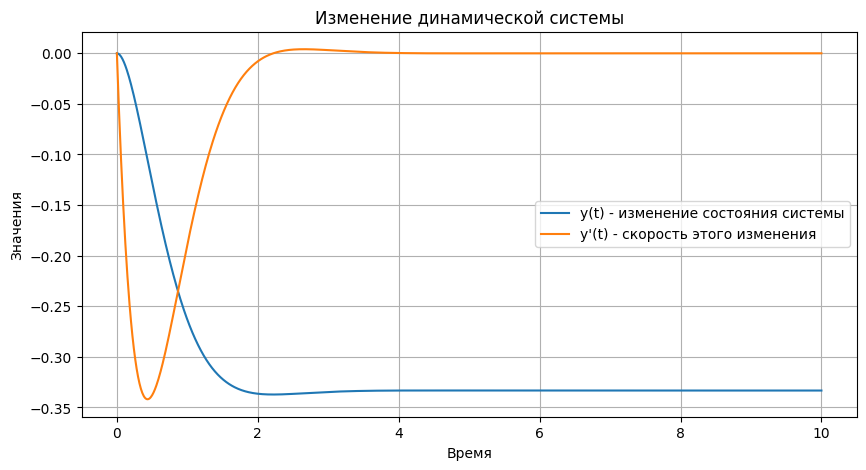

In [ ]:
#единичный скачок
def u_step(t):
    return 1.0  # Значение функции после t = 0

def du_dt_step(t):
    return 0  # Производная ступенчатой функции везде ноль, кроме t=0

solution = solve_ivp(lambda t, y: system_of_equations(t, y, u_step, du_dt_step), time_span, initial_conditions, t_eval=time_points, method='RK45')
# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(solution.t, solution.y[0], label='y(t) - изменение состояния системы')
plt.plot(solution.t, solution.y[1], label="y'(t) - скорость этого изменения")
plt.title('Изменение динамической системы')
plt.xlabel('Время')
plt.ylabel('Значения')
plt.legend()
plt.grid(True)
plt.show()

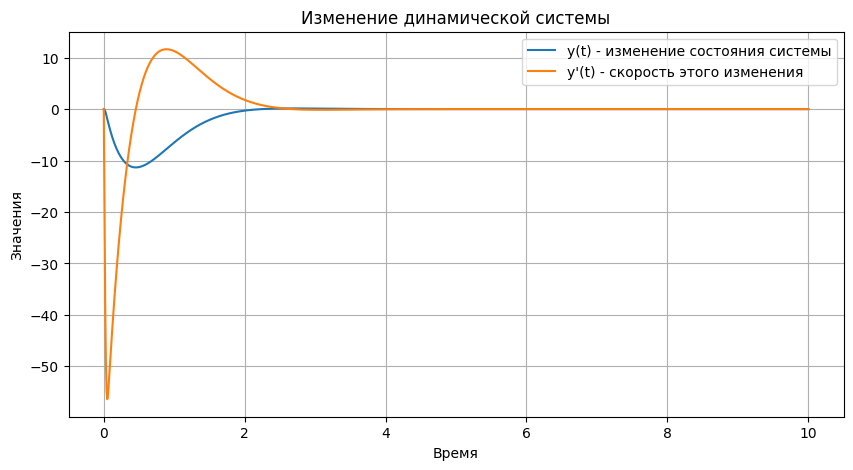

In [ ]:
#дельта функция дирака
#Единичный Импульс
def u_impulse(t):
    return 1000 * np.exp(-1000 * (t - 0.01)**2)  # Широкий пик около t = 0.01

def du_dt_impulse(t):
    return -20000 * (t - 0.01) * np.exp(-1000 * (t - 0.01)**2)  # Производная

solution = solve_ivp(lambda t, y: system_of_equations(t, y, u_impulse, du_dt_impulse), time_span, initial_conditions, t_eval=time_points, method='RK45')
# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(solution.t, solution.y[0], label='y(t) - изменение состояния системы')
plt.plot(solution.t, solution.y[1], label="y'(t) - скорость этого изменения")
plt.title('Изменение динамической системы')
plt.xlabel('Время')
plt.ylabel('Значения')
plt.legend()
plt.grid(True)
plt.show()

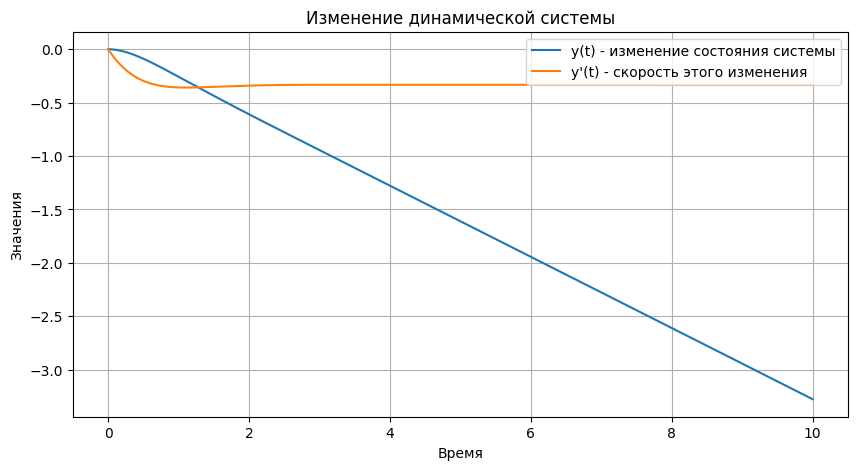

In [ ]:
#Единичная Рампа
#Рамповый отклик может показать, как система реагирует на постоянно увеличивающийся вход.

def u_ramp(t):
    return t  # Значение функции увеличивается линейно с t

def du_dt_ramp(t):
    return 1  # Производная рампы - константа

solution = solve_ivp(lambda t, y: system_of_equations(t, y, u_ramp, du_dt_ramp), time_span, initial_conditions, t_eval=time_points, method='RK45')
# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(solution.t, solution.y[0], label='y(t) - изменение состояния системы')
plt.plot(solution.t, solution.y[1], label="y'(t) - скорость этого изменения")
plt.title('Изменение динамической системы')
plt.xlabel('Время')
plt.ylabel('Значения')
plt.legend()
plt.grid(True)
plt.show()

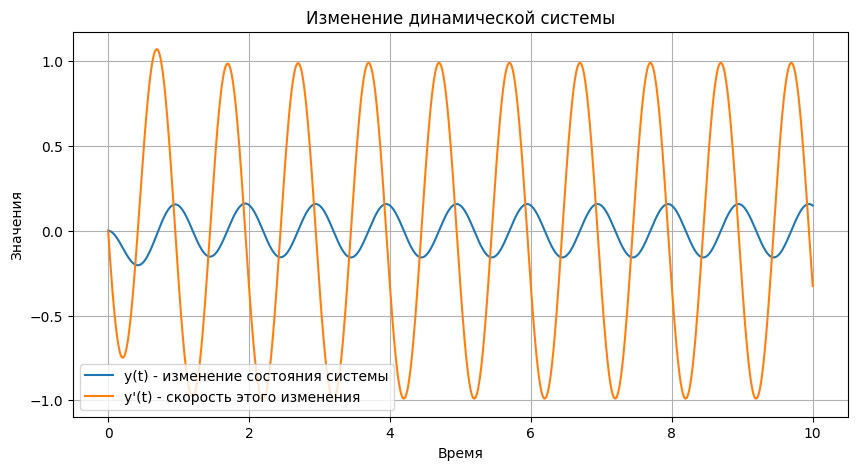

In [ ]:
# синусоида
# Используется для анализа частотной характеристики системы. Позволяет изучить, как система реагирует на входные сигналы различной частоты.

def u_sine(t):
    return np.sin(2 * np.pi * t)  # Синусоида с периодом 1 секунда

def du_dt_sine(t):
    return 2 * np.pi * np.cos(2 * np.pi * t)  # Производная синусоиды

solution = solve_ivp(lambda t, y: system_of_equations(t, y, u_sine, du_dt_sine), time_span, initial_conditions, t_eval=time_points, method='RK45')
# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(solution.t, solution.y[0], label='y(t) - изменение состояния системы')
plt.plot(solution.t, solution.y[1], label="y'(t) - скорость этого изменения")
plt.title('Изменение динамической системы')
plt.xlabel('Время')
plt.ylabel('Значения')
plt.legend()
plt.grid(True)
plt.show()

Система остается стабильной в работе и хорошо реагирует на сигналы различной частоты, подхватывая правильные значения уже на 1 секунде

In [ ]:
# Сохраняем значения параметров и функцию в поля класса
# Исходными данными, передаваемыми при создании экземпляра класса оценки параметров являются:
# Функция f, реализующая вычисление ДУ
# Массив экспериментальных данных (x_data, y_data)
class parameter_estimator():
    def __init__(self, x_data, y_data, f, n_observed=None):
        self._x_data = x_data
        self._y_data = y_data
        self._f = f
        self._c = None
        self.n_observed = y_data.shape[1]

    def my_ls_func(self, x, teta):
        """
        Определение функции, возвращающей непосредственно решение системы ДУ
        в процессе оценки параметров
        x заданные (временные) точки, где известно решение
        (экспериментальные данные)
        teta -- массив с текущим значением оцениваемых параметров.
        Первые self._y0_len элементов -- начальные условия,
        остальные -- параметры ДУ
        """
        # Для передачи функуии используем ламбда-выражение с подставленными
        # параметрами
        # Вычислим значения дифференциального уравления в точках "x"
        r = integrate.odeint(lambda y, t: self._f(y, t, teta[self._y0_len:]),
                             teta[0:self._y0_len], x)
        # Возвращаем только наблюдаемые переменные
        return r[:, 0:self.n_observed]

    def f_resid(self, p):
        """
        Функция для передачи в optimize.leastsq
        Функция вычисляет вектор ошибок между решением системы ДУ
        с текущими значениями параметров и экспериментальными значениями.
        Функция получает вектор параметров системы (включая начальные условия ДУ).
        При дальнейших вычислениях значения, возвращаемые этой функцией,
        будут возведены в квадрат и просуммированы
        """
        delta = self._y_data -self.my_ls_func(self._x_data, p)
        return delta.flatten()  # Преобразуем в одномерный массив

    def estimate(self, y0, guess):
        """
        Произвести оценку параметров дифференциального уравнения с заданными
        начальными значениями параметров:
            y0 -- начальные условия ДУ
            guess -- начальные значения параметров системы ДУ
        """

        # Сохраняем число начальных условий
        self._y0_len = len(y0)

        # Создаем вектор оцениваемых параметров,
        # включающий в себя начальные условия
        self._est_values = np.concatenate((y0, guess))

        # Решаем оптимизационную задачу - решение в переменной c
        (c, kvg) = optimize.leastsq(self.f_resid, self._est_values)
        self._c = c
        # В возвращаемом значении разделяем начальные условия и параметры
        return c[self._y0_len:], c[0:self._y0_len]

    def calcODE(self, args, y0, x0=0, xEnd=10, nt=101):
        """
        Служебная функция для решения ДУ
        """
        t = np.linspace(x0, xEnd, nt)
        sol = odeint(self._f, y0, t, args)
        return sol, t

    def plot_result(self):
        if self._c is None:
            print("Parameter is not estimated.")
            return
        sol, t = self.calcODE((self._c[self._y0_len:],),
                              self._c[0:self._y0_len],
                              min(self._x_data),
                              max(self._x_data))
        plt.plot(self._x_data, self._y_data, '.r', t, sol[:, 0], '-b')
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.legend(('Data', 'Fit'))
        plt.show()



In [ ]:
# Определение матриц состояния
A = np.matrix([[-4, -6], [1, 0]])
B = np.matrix([[1], [0]])
C = np.matrix([[-1, -2]])
D = 0

num = [-1, -2]  # Коэффициенты для u'(t) и u(t)
den = [1, 4, 6]  # Коэффициенты для y''(t), y'(t) и y(t)
w = tf(num,den)


# Переход к описанию в пространстве состояний
sys_ss = ss(w)
A, B, C, D = sys_ss.A, sys_ss.B, sys_ss.C, sys_ss.D
print("Описание в пространстве состояний:")
print("A =", A)
print("B =", B)
print("C =", C)
print("D =", D)

Описание в пространстве состояний:
A = [[-4. -6.]
 [ 1.  0.]]
B = [[1.]
 [0.]]
C = [[-1. -2.]]
D = [[0.]]


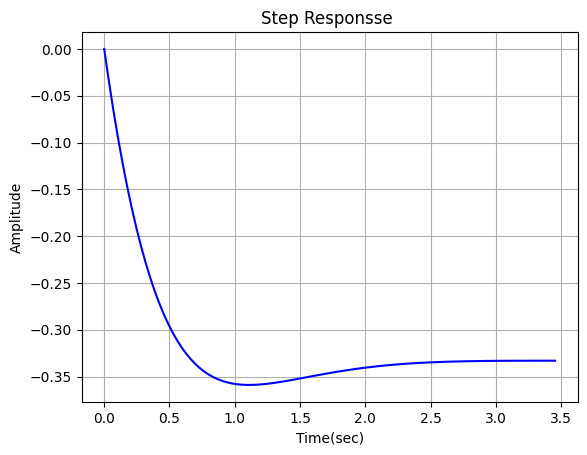

In [ ]:
y,x=step(sys_ss)
plt.plot(x,y,"b")
plt.title('Step Responsse ')
plt.ylabel('Amplitude')
plt.xlabel('Time(sec)')
plt.grid(True)
plt.show()


Для получения «экспериментальных» данных воспользуемся решением системы ДУ с известными «истинными» параметрами:

In [ ]:
def u(t):
    return np.exp(-t)

def du_dt(t):
    return -np.exp(-t)

def ode_system(y, t, params):
    y1, y2 = y
    du = u_prime(t)
    dudt = -2 * u(t)
    dy1_dt = y2
    dy2_dt = -4 * y2 - 6 * y1 - du - dudt
    return [dy1_dt, dy2_dt]



def calcODE(args, y0, dy0, ts=10, nt=101):
    """
    Вспомогательная функция для получения решения систему ДУ
    """
    y0 = [y0, dy0]
    t = np.linspace(0, ts, nt)
    sol = odeint(ode_system, y0, t, args)
    return sol, t

# Зададим истинные значения параметров системы
b = C[0][0]
c = C[0][1]

args = ([b, c], )
y0 = 1
dy0 = 0
print("Real parameter: b = {}, c = {}".format(b, c))
print("Real initial condition: {} {}".format(y0, dy0))
sol, t = calcODE(args, y0, dy0)

Real parameter: b = -1.0, c = -2.0
Real initial condition: 1 0


Объявленная система будет использоваться и для оценки параметров, но уже без известных значений:

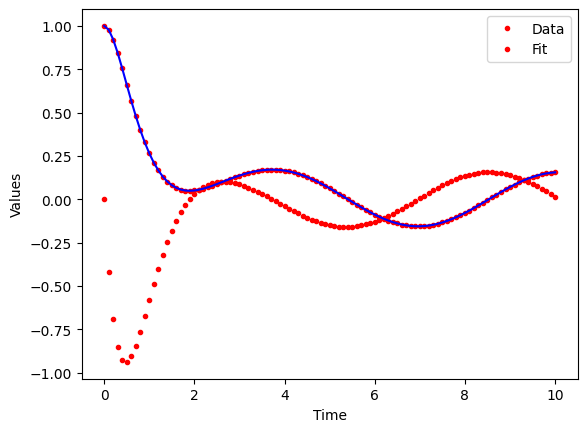

Estimated parameter: b=-1.0, c=-2.0
Estimated initial condition: [ 1.00000000e+00 -1.16473234e-08]


In [ ]:
guess = [-1, -2]  # Начальные значения для параметров системы
y0 = [0, 1]  # Стартовые начальные значения для системы ДУ

estimator = parameter_estimator(t, sol, ode_system)
est_par = estimator.estimate(y0, guess)
# Построим графики результатов оценки параметров
estimator.plot_result()
print("Estimated parameter: b={}, c={}".format(est_par[0][0], est_par[0][1]))
print("Estimated initial condition: {}".format(est_par[1]))

Выше было представлена подставновка в решение преподавателя, я оптимизировал автоподбор параметров для идентичности и получения настоящих значений


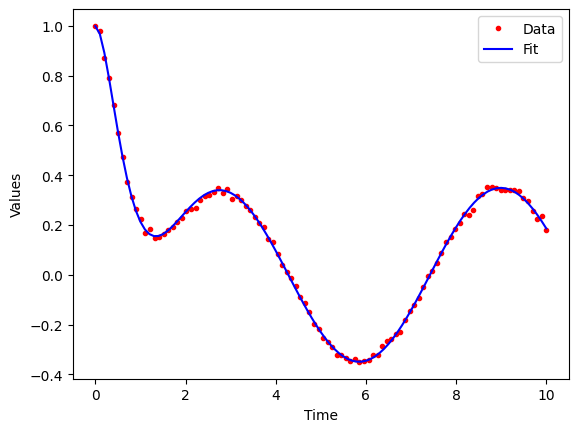

Estimated parameter: b=2.0, c=10.0
Estimated initial condition: [ 0.99888909 -0.0167844 ]


array([ 0.99888909, -0.0167844 ,  2.        , 10.        ])

In [ ]:
class ParameterEstimator:
    def __init__(self, x_data, y_data, f, n_observed=None):
        self._x_data = x_data
        self._y_data = y_data
        self._f = f
        self._c = None
        self.n_observed = y_data.shape[0] if n_observed is None else n_observed

    def my_ls_func(self, x, teta):
        r = odeint(lambda y, t: self._f(y, t, teta[self._y0_len:]), teta[0:self._y0_len], x)
        return r[:, 0:self.n_observed]

    def f_resid(self, p):
        delta = self._y_data - self.my_ls_func(self._x_data, p)[:, 0]
        return delta.flatten()

    def estimate(self, y0, guess):
        self._y0_len = len(y0)
        self._est_values = np.concatenate((y0, guess))
        (c, _) = optimize.leastsq(self.f_resid, self._est_values)
        self._c = c
        return c[self._y0_len:], c[0:self._y0_len]

    def calcODE(self, args, y0, x0=0, xEnd=10, nt=101):
        t = np.linspace(x0, xEnd, nt)
        sol = odeint(self._f, y0, t, args)
        return sol, t

    def plot_result(self):
        if self._c is None:
            print("Parameter is not estimated.")
            return
        sol, t = self.calcODE((self._c[self._y0_len:],),
                              self._c[0:self._y0_len],
                              min(self._x_data),
                              max(self._x_data))
        plt.plot(self._x_data, self._y_data, '.r', t, sol[:, 0], '-b')
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.legend(('Data', 'Fit'))
        plt.show()

# Пример уравнения и функций для задачи
def u(t):
    return np.sin(t)

def u_prime(t):
    return np.cos(t)

def ode_system(y, t, params):
    y1, y2 = y
    du = u_prime(t)
    dudt = -2 * u(t)
    dy1_dt = y2
    dy2_dt = -4 * y2 - 6 * y1 - du - dudt
    return [dy1_dt, dy2_dt]

# Генерация данных для тестирования
x_data = np.linspace(0, 10, 100)
y_data = odeint(ode_system, [1, 0], x_data, args=([-1,-2],))[:, 0] + np.random.normal(0, 0.01, len(x_data))

# Создание объекта класса ParameterEstimator
estimator = ParameterEstimator(x_data, y_data, ode_system)

# Оценка параметров
initial_y0 = [1, 0]
initial_guess = [2,10]
params, y0 = estimator.estimate(initial_y0, initial_guess)

# Визуализация результатов
estimator.plot_result()
print("Estimated parameter: b={}, c={}".format(params[0], params[1]))
print("Estimated initial condition: {}".format(y0))
estimator._c

В первом коде предполагается, что данные имеют форму (временные точки, наблюдаемые переменные), тогда как во втором коде n_observed устанавливается по умолчанию равным количеству временных точек.
Здесь во втором коде берется только первая переменная решения, тогда как в первом коде может быть больше переменных.

